# Model Robustness

**Objectives**
- Load the Model(s)
- Run predictions on the model using the Holdout/Test Datasplit (better if the malicious samples are verified for malware types)
- Record instances where the model failed to predict correctly
- Record the performance of the models (e.g., Accuracy, Precision, Recall, ROC-AUC, etc.)

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgbm
import catboost as catb

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, average_precision_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay

from joblib import load
import warnings
warnings.filterwarnings("ignore")

## 1. Determine the Model Performance in each of the GBDT Models and each of its two behavior-types.

`How does the model perform using 'real-world' data (i.e., Test/Holdout Split)?`

Run other metrics as well as you see fit that are not found in the classification_report and Confusion Matrix.

- Label column is `0/'malicious'`
- Feature column is `[:, 1:101]`

### 1.1 Defining a helper function for evaluation


In [2]:
def evaluate(model, test_set, y_actual):
    y_pred = model.predict(test_set)
    cm = confusion_matrix(y_actual, y_pred)
    print(classification_report(y_actual, y_pred, digits=4))
    print(f"AUC-ROC Score: {roc_auc_score(y_actual, y_pred):.4f}")
    print("ROC Curve & Confusion matrix:")
    RocCurveDisplay.from_predictions(y_actual, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    #print(classification_report(y_actual, y_pred, digits=4))
    

### 1.2 LightGBM

In [3]:
DF_LGBM_TB = pd.read_csv('Dataset/LGBM_TB_Test.csv', low_memory=False) #<== Point these to the proper Test/Holdout datasets.
DF_LGBM_IB = pd.read_csv('Dataset/LGBM_IB_Test.csv', low_memory=False)

display(DF_LGBM_TB.head())
print(DF_LGBM_TB['type'].unique())
display(DF_LGBM_IB.head())
print(DF_LGBM_IB['type'].unique())

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,208,172,240,117,240,262,112,123,65,...,274,215,274,215,274,215,274,215,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,112,274,158,215,274,158,215,298,76,...,297,135,171,215,35,208,56,71,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,215,274,158,215,274,158,215,172,117,...,15,240,117,240,117,240,117,172,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,82,240,117,240,117,240,117,240,117,...,208,93,208,16,31,215,108,208,24dd4677c14eb5828bda78749fded6b8,pua
4,1,112,274,158,215,274,158,215,298,76,...,297,135,171,215,35,208,56,71,cc5d38cb80faaf60d8efabecdc04f832,trojan


['trojan' 'pua' 'adware' 'downloader' 'hacktool' 'benign' 'worm'
 'ransomware' 'miner' 'virus' 'spyware']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,208,172,240,117,262,112,123,65,274,...,307,307,307,307,307,307,307,307,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,112,274,158,215,298,76,208,172,117,...,307,307,307,307,307,307,307,307,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,215,274,158,172,117,198,208,260,257,...,307,307,307,307,307,307,307,307,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,82,240,117,93,16,228,208,198,86,...,307,307,307,307,307,307,307,307,24dd4677c14eb5828bda78749fded6b8,pua
4,1,112,274,158,215,298,76,208,172,117,...,307,307,307,307,307,307,307,307,cc5d38cb80faaf60d8efabecdc04f832,trojan


['trojan' 'pua' 'adware' 'downloader' 'hacktool' 'benign' 'worm'
 'ransomware' 'miner' 'virus' 'spyware']


In [4]:
# Load trained LightGBM model files
default_tb = load('Models/LGBM/Default/Manual_RYZEN3c_LGBM_TB.model') # <== Point these to the respective .model files
default_ib = load('Models/LGBM/Default/Manual_RYZEN3c_LGBM_IB.model')
tuned_tb = load('Models/LGBM/Tuned/TUNED_Manual_RYZEN3c_LGBM_TB.model')
tuned_ib = load('Models/LGBM/Tuned/TUNED_Manual_RYZEN3c_LGBM_IB.model')

1. Default LGBM TB

              precision    recall  f1-score   support

           0     0.9487    0.6491    0.7708       114
           1     0.9901    0.9990    0.9945      4010

    accuracy                         0.9893      4124
   macro avg     0.9694    0.8241    0.8827      4124
weighted avg     0.9890    0.9893    0.9884      4124

AUC-ROC Score: 0.8241
ROC Curve & Confusion matrix:


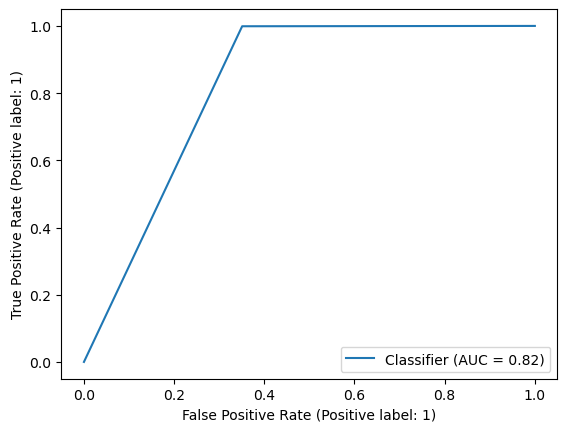

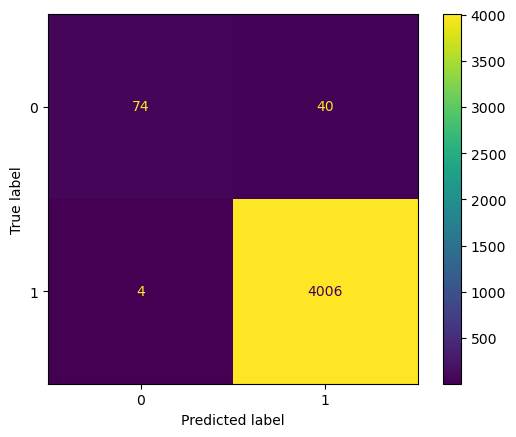

In [5]:
print("1. Default LGBM TB\n")
evaluate(default_tb, DF_LGBM_TB.iloc[:,1:101], DF_LGBM_TB.iloc[:,0])

2. Default LGBM IB

              precision    recall  f1-score   support

           0     0.9157    0.6667    0.7716       114
           1     0.9906    0.9983    0.9944      4010

    accuracy                         0.9891      4124
   macro avg     0.9531    0.8325    0.8830      4124
weighted avg     0.9885    0.9891    0.9883      4124

AUC-ROC Score: 0.8325
ROC Curve & Confusion matrix:


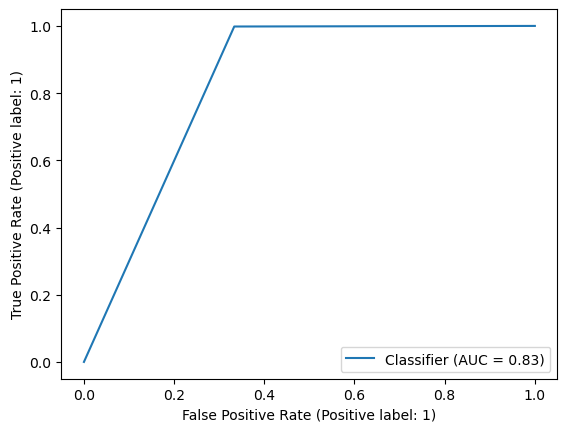

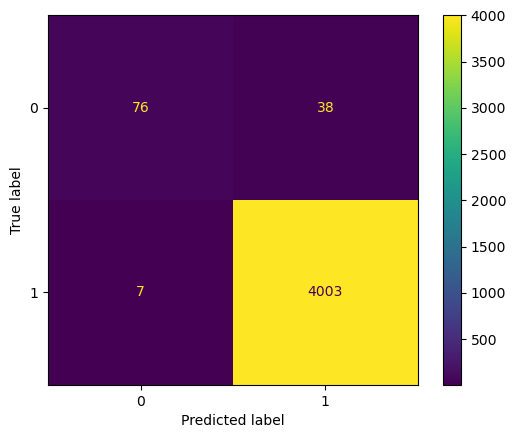

In [6]:
print("2. Default LGBM IB\n")
evaluate(default_ib, DF_LGBM_IB.iloc[:,1:101], DF_LGBM_IB.iloc[:,0])

3. Tuned LGBM TB

              precision    recall  f1-score   support

           0     0.9512    0.6842    0.7959       114
           1     0.9911    0.9990    0.9950      4010

    accuracy                         0.9903      4124
   macro avg     0.9712    0.8416    0.8955      4124
weighted avg     0.9900    0.9903    0.9895      4124

AUC-ROC Score: 0.8416
ROC Curve & Confusion matrix:


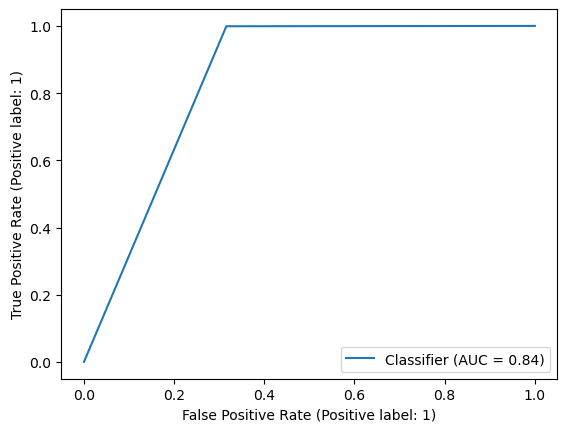

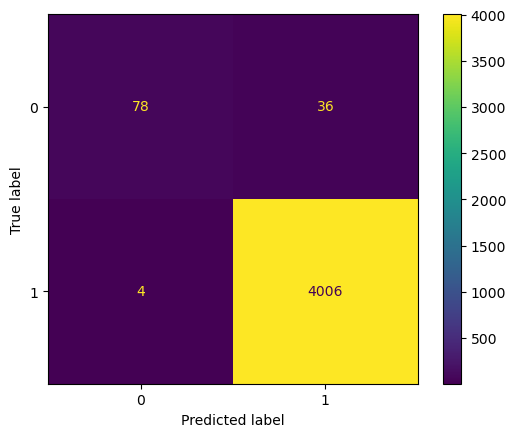

In [7]:
print("3. Tuned LGBM TB\n")
evaluate(tuned_tb, DF_LGBM_TB.iloc[:,1:101], DF_LGBM_TB.iloc[:,0])

4. Tuned LGBM IB

              precision    recall  f1-score   support

           0     0.9518    0.6930    0.8020       114
           1     0.9913    0.9990    0.9952      4010

    accuracy                         0.9905      4124
   macro avg     0.9716    0.8460    0.8986      4124
weighted avg     0.9902    0.9905    0.9898      4124

AUC-ROC Score: 0.8460
ROC Curve & Confusion matrix:


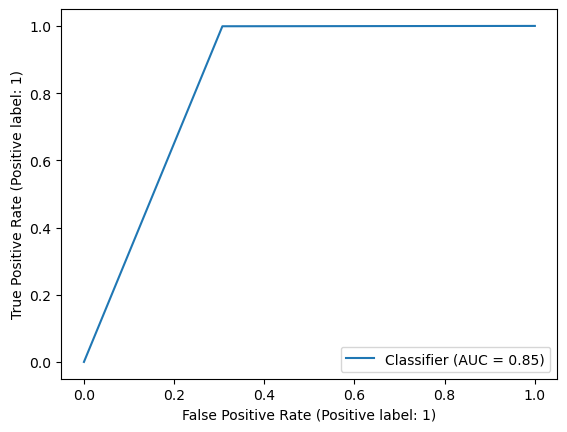

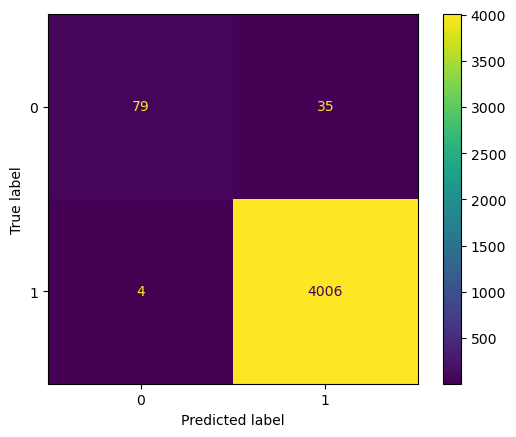

In [8]:
print("4. Tuned LGBM IB\n")
evaluate(tuned_ib, DF_LGBM_IB.iloc[:,1:101], DF_LGBM_IB.iloc[:,0])

### 1.3 CatBoost

In [9]:
DF_CATB_TB = pd.read_csv('Dataset/CATB_TB_Test.csv', low_memory=False) #<== Point these to the proper Test/Holdout datasets.
DF_CATB_IB = pd.read_csv('Dataset/CATB_IB_Test.csv', low_memory=False)

DF_CATB_IB.iloc[:,1:101] = DF_CATB_IB.iloc[:,1:101].astype('str')
DF_CATB_IB.replace("nan", "NaN", inplace=True)

#DF_CATB_TB = DF_CATB_TB[DF_CATB_TB['Type 1'] != '_']
#DF_CATB_IB = DF_CATB_IB[DF_CATB_IB['Type 1'] != '_']

display(DF_CATB_TB.head())
print(DF_CATB_TB['type'].unique())
display(DF_CATB_IB.head())
print(DF_CATB_IB['type'].unique())

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,NtAllocateVirtualMemory,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,NtQuerySystemInformation,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,...,NtOpenKey,NtClose,NtOpenKey,NtClose,NtOpenKey,NtClose,NtOpenKey,NtClose,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,LookupAccountSidW,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtAllocateVirtualMemory,GetFileType,NtAllocateVirtualMemory,SetUnhandledExceptionFilter,CoInitializeEx,NtClose,WSAStartup,NtAllocateVirtualMemory,24dd4677c14eb5828bda78749fded6b8,pua
4,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,cc5d38cb80faaf60d8efabecdc04f832,trojan


['trojan' 'pua' 'adware' 'downloader' 'hacktool' 'benign' 'worm'
 'ransomware' 'miner' 'virus' 'spyware']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,NtAllocateVirtualMemory,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,NtQuerySystemInformation,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,NtOpenKey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,GetFileType,SetUnhandledExceptionFilter,NtProtectVirtualMemory,NtAllocateVirtualMemory,GetSystemInfo,NtCreateMutant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24dd4677c14eb5828bda78749fded6b8,pua
4,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cc5d38cb80faaf60d8efabecdc04f832,trojan


['trojan' 'pua' 'adware' 'downloader' 'hacktool' 'benign' 'worm'
 'ransomware' 'miner' 'virus' 'spyware']


In [10]:
# Load trained CatBoost model files (CatBoost requires instantiation before being able to load a trianed model file).
default_tb = catb.CatBoostClassifier()
default_ib = catb.CatBoostClassifier()
tuned_tb = catb.CatBoostClassifier()
tuned_ib = catb.CatBoostClassifier()
default_tb = default_tb.load_model("Models/CATB/Default/Manual_RYZEN3c_CATB_TB.model", format='json') # <== Point these to the respective .model files
default_ib = default_ib.load_model("Models/CATB/Default/Manual_RYZEN3c_CATB_IB.model", format='json')
tuned_tb = tuned_tb.load_model("Models/CATB/Tuned/TUNED_Manual_RYZEN3c_CATB_TB.model", format='json')
tuned_ib = tuned_ib.load_model("Models/CATB/Tuned/TUNED_Manual_RYZEN3c_CATB_IB.model", format='json')

1. Default CatBoost TB

              precision    recall  f1-score   support

           0     0.9467    0.6228    0.7513       114
           1     0.9894    0.9990    0.9942      4010

    accuracy                         0.9886      4124
   macro avg     0.9680    0.8109    0.8727      4124
weighted avg     0.9882    0.9886    0.9875      4124

AUC-ROC Score: 0.8109
ROC Curve & Confusion matrix:


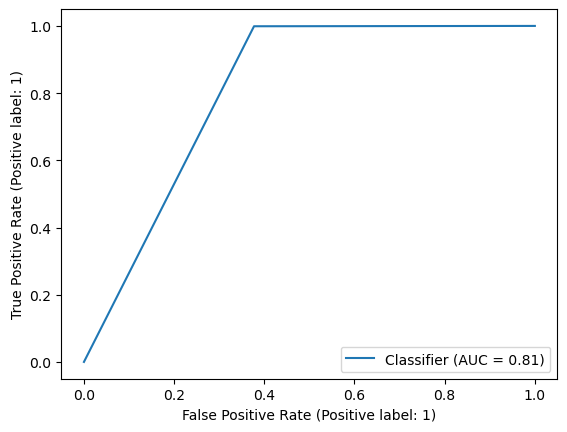

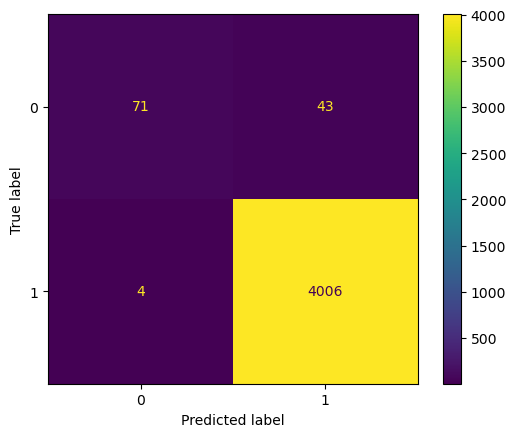

In [11]:
print("1. Default CatBoost TB\n")
evaluate(default_tb, DF_CATB_TB.iloc[:,1:101], DF_CATB_TB.iloc[:,0])

2. Default CatBoost IB

              precision    recall  f1-score   support

           0     0.9390    0.6754    0.7857       114
           1     0.9908    0.9988    0.9948      4010

    accuracy                         0.9898      4124
   macro avg     0.9649    0.8371    0.8902      4124
weighted avg     0.9894    0.9898    0.9890      4124

AUC-ROC Score: 0.8371
ROC Curve & Confusion matrix:


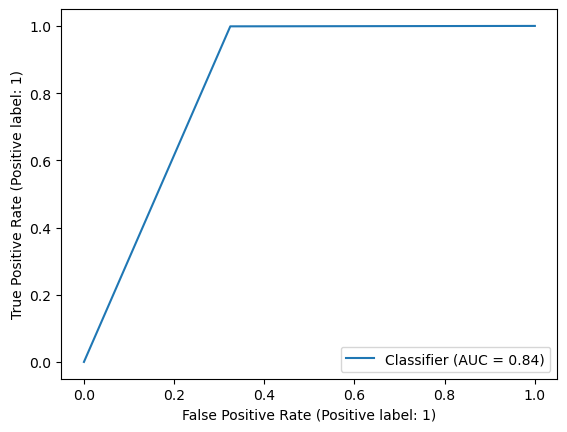

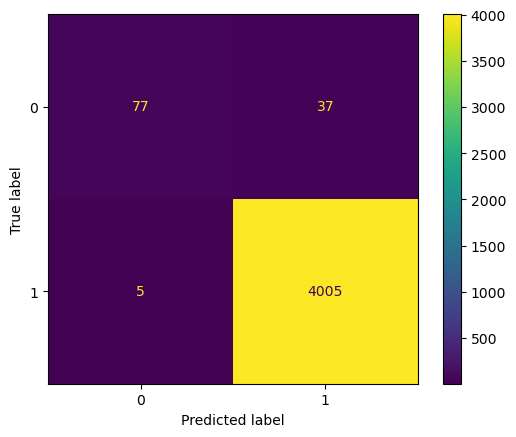

In [12]:
print("2. Default CatBoost IB\n")
evaluate(default_ib, DF_CATB_IB.iloc[:,1:101], DF_CATB_IB.iloc[:,0])

3. Tuned CatBoost TB

              precision    recall  f1-score   support

           0     0.9136    0.6491    0.7590       114
           1     0.9901    0.9983    0.9942      4010

    accuracy                         0.9886      4124
   macro avg     0.9518    0.8237    0.8766      4124
weighted avg     0.9880    0.9886    0.9877      4124

AUC-ROC Score: 0.8237
ROC Curve & Confusion matrix:


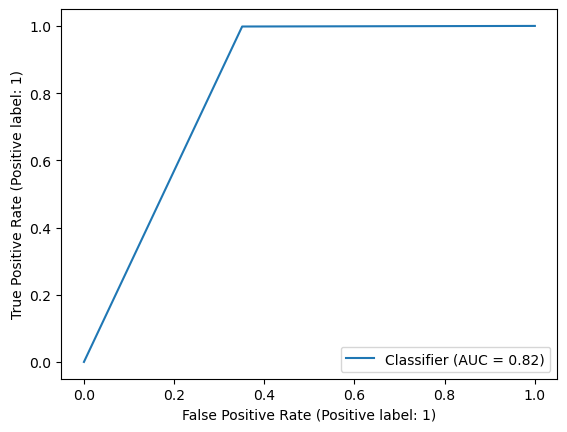

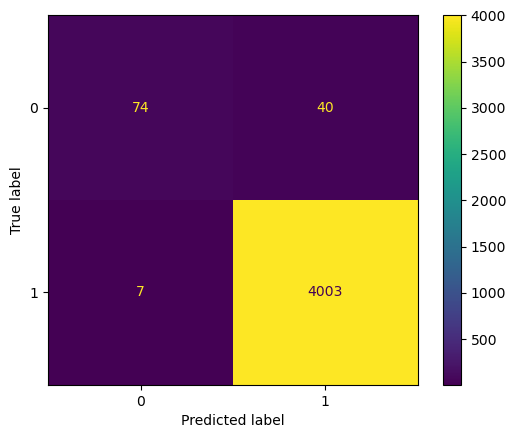

In [13]:
print("3. Tuned CatBoost TB\n")
evaluate(tuned_tb, DF_CATB_TB.iloc[:,1:101], DF_CATB_TB.iloc[:,0])

4. Tuned CatBoost IB

              precision    recall  f1-score   support

           0     0.9101    0.7105    0.7980       114
           1     0.9918    0.9980    0.9949      4010

    accuracy                         0.9901      4124
   macro avg     0.9510    0.8543    0.8965      4124
weighted avg     0.9896    0.9901    0.9895      4124

AUC-ROC Score: 0.8543
ROC Curve & Confusion matrix:


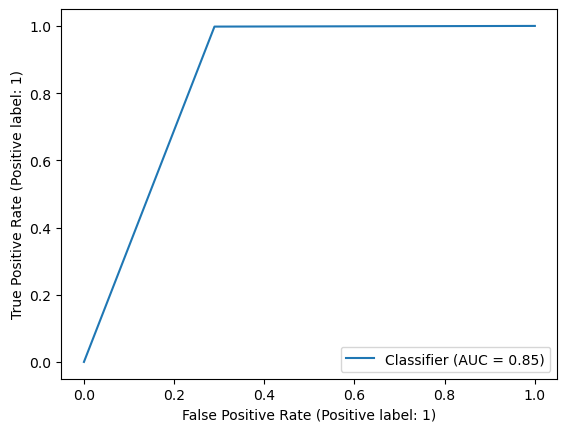

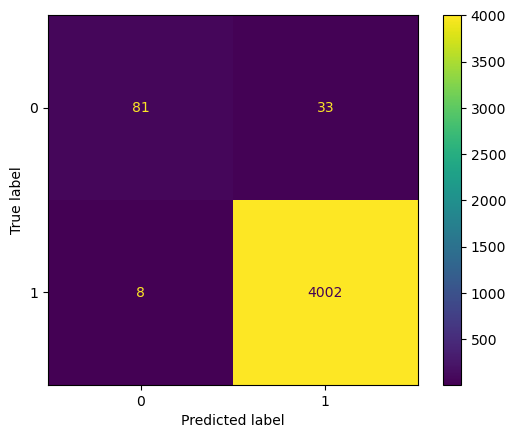

In [14]:
print("4. Tuned CatBoost IB\n")
evaluate(tuned_ib, DF_CATB_IB.iloc[:,1:101], DF_CATB_IB.iloc[:,0])

## 2. Check for model capabilities at a malware type level in each GBDT Models and each of its two behavior-types.

Using the `xx` dataset, determine the prediction capability of the model in each malware type.

**Answer this question:**

`How good are the model (as per classification report and confusion matrix) on a per-malware type basis?`

The theory is that malware-types that are prominent in terms of quantity might be detected accurately as malware than those that are not. 

### 2.1 Defining a helper function

In [15]:
def evaluate_per_type(model, test_set, mal_type):
    filtered_set = test_set.loc[(test_set['type'] == 'benign') | (test_set['type'] == mal_type)]
    y_pred = model.predict(filtered_set.iloc[:,1:101])
    acc = accuracy_score(filtered_set.iloc[:,0], y_pred)
    prec = precision_score(filtered_set.iloc[:,0], y_pred)
    rec = recall_score(filtered_set.iloc[:,0], y_pred)
    auc_roc = roc_auc_score(filtered_set.iloc[:,0], y_pred)
    f1 = f1_score(filtered_set.iloc[:,0], y_pred)
    cm = confusion_matrix(filtered_set.iloc[:,0], y_pred)
    print("Malware Type: " + mal_type)
    print("==========================")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc_roc:.4f}")
    print(f"TN: {cm[0,0]:4d} FN: {cm[1,0]:4d}")
    print(f"TP: {cm[1,1]:4d} FP: {cm[0,1]:4d}")
    print("")

### 2.1 LightGBM

In [16]:
#Load Verified Test/Holodut Dataset
DF_LGBM_TB = pd.read_csv('./Dataset/LGBM_TB_Test.csv', low_memory=False)
DF_LGBM_IB = pd.read_csv('./Dataset/LGBM_IB_Test.csv', low_memory=False)

# No need to drop these "_" muna, assume na walang false-labelled malicious samples (pa-comment out nalang muna).
# DF_LGBM_TB = DF_LGBM_TB[DF_LGBM_TB['type'] != '_']
# DF_LGBM_IB = DF_LGBM_IB[DF_LGBM_IB['type'] != '_']
DF_LGBM_TB = DF_LGBM_TB.dropna()
DF_LGBM_IB = DF_LGBM_IB.dropna()

#Models
default_tb = load('Models/LGBM/Default/Manual_RYZEN3c_LGBM_TB.model') # <== Point these to the respective .model files
default_ib = load('Models/LGBM/Default/Manual_RYZEN3c_LGBM_IB.model')
tuned_tb = load('Models/LGBM/Tuned/TUNED_Manual_RYZEN3c_LGBM_TB.model')
tuned_ib = load('Models/LGBM/Tuned/TUNED_Manual_RYZEN3c_LGBM_IB.model')

display(DF_LGBM_TB)
print("DF_LGBM_TB:", DF_LGBM_TB['type'].unique().tolist())
display(DF_LGBM_IB)
print("DF_LGBM_IB:", DF_LGBM_IB['type'].unique().tolist())

'''
COLUMNS:
Features = [:, 1:101]
Label = [:, 0]
Hash = [:, 101]
Type 1 (malware type) = [:, 102]
'''

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,208,172,240,117,240,262,112,123,65,...,274,215,274,215,274,215,274,215,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,112,274,158,215,274,158,215,298,76,...,297,135,171,215,35,208,56,71,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,215,274,158,215,274,158,215,172,117,...,15,240,117,240,117,240,117,172,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,82,240,117,240,117,240,117,240,117,...,208,93,208,16,31,215,108,208,24dd4677c14eb5828bda78749fded6b8,pua
4,1,112,274,158,215,274,158,215,298,76,...,297,135,171,215,35,208,56,71,cc5d38cb80faaf60d8efabecdc04f832,trojan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,1,82,240,117,240,117,93,117,16,147,...,230,240,117,225,35,208,89,225,5a99618b63178d7a221552fe962992e3,trojan
4120,1,112,274,158,215,274,158,215,298,76,...,117,76,172,117,286,172,117,275,45bf43151fd02d4ea1d1028386d12d06,trojan
4121,1,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,cf6242404774ee9d15c67c75c80e1a14,trojan
4122,1,82,240,117,240,117,240,117,240,117,...,215,208,297,93,303,264,187,208,6536fb7723a2a091fdd2610a36b32741,trojan


DF_LGBM_TB: ['trojan', 'pua', 'adware', 'downloader', 'hacktool', 'benign', 'worm', 'ransomware', 'miner', 'virus', 'spyware']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,208,172,240,117,262,112,123,65,274,...,307,307,307,307,307,307,307,307,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,112,274,158,215,298,76,208,172,117,...,307,307,307,307,307,307,307,307,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,215,274,158,172,117,198,208,260,257,...,307,307,307,307,307,307,307,307,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,82,240,117,93,16,228,208,198,86,...,307,307,307,307,307,307,307,307,24dd4677c14eb5828bda78749fded6b8,pua
4,1,112,274,158,215,298,76,208,172,117,...,307,307,307,307,307,307,307,307,cc5d38cb80faaf60d8efabecdc04f832,trojan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,1,82,240,117,93,16,147,228,208,71,...,307,307,307,307,307,307,307,307,5a99618b63178d7a221552fe962992e3,trojan
4120,1,112,274,158,215,298,76,208,172,117,...,307,307,307,307,307,307,307,307,45bf43151fd02d4ea1d1028386d12d06,trojan
4121,1,82,240,117,172,16,11,274,158,215,...,307,307,307,307,307,307,307,307,cf6242404774ee9d15c67c75c80e1a14,trojan
4122,1,82,240,117,16,297,93,303,264,215,...,307,307,307,307,307,307,307,307,6536fb7723a2a091fdd2610a36b32741,trojan


DF_LGBM_IB: ['trojan', 'pua', 'adware', 'downloader', 'hacktool', 'benign', 'worm', 'ransomware', 'miner', 'virus', 'spyware']


'\nCOLUMNS:\nFeatures = [:, 1:101]\nLabel = [:, 0]\nHash = [:, 101]\nType 1 (malware type) = [:, 102]\n'

In [17]:
print("1. Default LGBM TB\n")
for mal_type in DF_LGBM_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_tb, DF_LGBM_TB, mal_type)

1. Default LGBM TB

Malware Type: trojan
Accuracy:  0.9873
Precision: 0.9879
Recall:    0.9991
F1 Score:  0.9934
AUC-ROC:   0.8241
TN:   74 FN:    3
TP: 3256 FP:   40

Malware Type: pua
Accuracy:  0.8798
Precision: 0.8496
Recall:    0.9956
F1 Score:  0.9168
AUC-ROC:   0.8224
TN:   74 FN:    1
TP:  226 FP:   40

Malware Type: adware
Accuracy:  0.8795
Precision: 0.8450
Recall:    1.0000
F1 Score:  0.9160
AUC-ROC:   0.8246
TN:   74 FN:    0
TP:  218 FP:   40

Malware Type: downloader
Accuracy:  0.8895
Precision: 0.8611
Recall:    1.0000
F1 Score:  0.9254
AUC-ROC:   0.8246
TN:   74 FN:    0
TP:  248 FP:   40

Malware Type: hacktool
Accuracy:  0.6552
Precision: 0.0476
Recall:    1.0000
F1 Score:  0.0909
AUC-ROC:   0.8246
TN:   74 FN:    0
TP:    2 FP:   40

Malware Type: worm
Accuracy:  0.6522
Precision: 0.0244
Recall:    1.0000
F1 Score:  0.0476
AUC-ROC:   0.8246
TN:   74 FN:    0
TP:    1 FP:   40

Malware Type: ransomware
Accuracy:  0.7279
Precision: 0.4521
Recall:    1.0000
F1 Score:  0

In [18]:
print("2. Default LGBM IB\n")
for mal_type in DF_LGBM_IB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_ib, DF_LGBM_IB, mal_type)

2. Default LGBM IB

Malware Type: trojan
Accuracy:  0.9870
Precision: 0.9885
Recall:    0.9982
F1 Score:  0.9933
AUC-ROC:   0.8324
TN:   76 FN:    6
TP: 3253 FP:   38

Malware Type: pua
Accuracy:  0.8886
Precision: 0.8566
Recall:    1.0000
F1 Score:  0.9228
AUC-ROC:   0.8333
TN:   76 FN:    0
TP:  227 FP:   38

Malware Type: adware
Accuracy:  0.8855
Precision: 0.8516
Recall:    1.0000
F1 Score:  0.9198
AUC-ROC:   0.8333
TN:   76 FN:    0
TP:  218 FP:   38

Malware Type: downloader
Accuracy:  0.8923
Precision: 0.8667
Recall:    0.9960
F1 Score:  0.9268
AUC-ROC:   0.8313
TN:   76 FN:    1
TP:  247 FP:   38

Malware Type: hacktool
Accuracy:  0.6724
Precision: 0.0500
Recall:    1.0000
F1 Score:  0.0952
AUC-ROC:   0.8333
TN:   76 FN:    0
TP:    2 FP:   38

Malware Type: worm
Accuracy:  0.6696
Precision: 0.0256
Recall:    1.0000
F1 Score:  0.0500
AUC-ROC:   0.8333
TN:   76 FN:    0
TP:    1 FP:   38

Malware Type: ransomware
Accuracy:  0.7415
Precision: 0.4648
Recall:    1.0000
F1 Score:  0

In [19]:
print("3. Tuned LGBM TB\n")
for mal_type in DF_LGBM_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_tb, DF_LGBM_TB, mal_type)

3. Tuned LGBM TB

Malware Type: trojan
Accuracy:  0.9884
Precision: 0.9891
Recall:    0.9991
F1 Score:  0.9940
AUC-ROC:   0.8416
TN:   78 FN:    3
TP: 3256 FP:   36

Malware Type: pua
Accuracy:  0.8915
Precision: 0.8626
Recall:    0.9956
F1 Score:  0.9243
AUC-ROC:   0.8399
TN:   78 FN:    1
TP:  226 FP:   36

Malware Type: adware
Accuracy:  0.8916
Precision: 0.8583
Recall:    1.0000
F1 Score:  0.9237
AUC-ROC:   0.8421
TN:   78 FN:    0
TP:  218 FP:   36

Malware Type: downloader
Accuracy:  0.9006
Precision: 0.8732
Recall:    1.0000
F1 Score:  0.9323
AUC-ROC:   0.8421
TN:   78 FN:    0
TP:  248 FP:   36

Malware Type: hacktool
Accuracy:  0.6897
Precision: 0.0526
Recall:    1.0000
F1 Score:  0.1000
AUC-ROC:   0.8421
TN:   78 FN:    0
TP:    2 FP:   36

Malware Type: worm
Accuracy:  0.6870
Precision: 0.0270
Recall:    1.0000
F1 Score:  0.0526
AUC-ROC:   0.8421
TN:   78 FN:    0
TP:    1 FP:   36

Malware Type: ransomware
Accuracy:  0.7551
Precision: 0.4783
Recall:    1.0000
F1 Score:  0.6

In [20]:
print("4. Tuned LGBM IB\n")
for mal_type in DF_LGBM_IB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_ib, DF_LGBM_IB, mal_type)

4. Tuned LGBM IB

Malware Type: trojan
Accuracy:  0.9887
Precision: 0.9894
Recall:    0.9991
F1 Score:  0.9942
AUC-ROC:   0.8460
TN:   79 FN:    3
TP: 3256 FP:   35

Malware Type: pua
Accuracy:  0.8974
Precision: 0.8664
Recall:    1.0000
F1 Score:  0.9284
AUC-ROC:   0.8465
TN:   79 FN:    0
TP:  227 FP:   35

Malware Type: adware
Accuracy:  0.8946
Precision: 0.8617
Recall:    1.0000
F1 Score:  0.9257
AUC-ROC:   0.8465
TN:   79 FN:    0
TP:  218 FP:   35

Malware Type: downloader
Accuracy:  0.9006
Precision: 0.8759
Recall:    0.9960
F1 Score:  0.9321
AUC-ROC:   0.8445
TN:   79 FN:    1
TP:  247 FP:   35

Malware Type: hacktool
Accuracy:  0.6983
Precision: 0.0541
Recall:    1.0000
F1 Score:  0.1026
AUC-ROC:   0.8465
TN:   79 FN:    0
TP:    2 FP:   35

Malware Type: worm
Accuracy:  0.6957
Precision: 0.0278
Recall:    1.0000
F1 Score:  0.0541
AUC-ROC:   0.8465
TN:   79 FN:    0
TP:    1 FP:   35

Malware Type: ransomware
Accuracy:  0.7619
Precision: 0.4853
Recall:    1.0000
F1 Score:  0.6

### 2.2 CatBoost

In [21]:
#Load Verified Test/Holdout Dataset
DF_CATB_TB = pd.read_csv('./Dataset/CATB_TB_Test.csv', low_memory=False)
DF_CATB_IB = pd.read_csv('./Dataset/CATB_IB_Test.csv', low_memory=False)

# DF_CATB_TB = DF_CATB_TB[DF_CATB_TB['type'] != '_']
# DF_CATB_IB = DF_CATB_IB[DF_CATB_IB['type'] != '_']
DF_CATB_TB = DF_CATB_TB.dropna()
DF_CATB_IB = DF_CATB_IB.dropna(subset=['type']) # Drops na only on type column
DF_CATB_IB.iloc[:,1:101] = DF_CATB_IB.iloc[:,1:101].astype('str')
DF_CATB_IB.replace("nan", "NaN", inplace=True)

default_tb = catb.CatBoostClassifier()
default_ib = catb.CatBoostClassifier()
tuned_tb = catb.CatBoostClassifier()
tuned_ib = catb.CatBoostClassifier()
default_tb = default_tb.load_model("./Models/CATB/Default/Manual_RYZEN3c_CATB_TB.model", format='json')
default_ib = default_ib.load_model("./Models/CATB/Default/Manual_RYZEN3c_CATB_IB.model", format='json')
tuned_tb = tuned_tb.load_model("./Models/CATB/Tuned/TUNED_Manual_RYZEN3c_CATB_TB.model", format='json')
tuned_ib = tuned_ib.load_model("./Models/CATB/Tuned/TUNED_Manual_RYZEN3c_CATB_IB.model", format='json')

display(DF_CATB_TB)
print("DF_CATB_TB:", DF_CATB_TB['type'].unique().tolist())
display(DF_CATB_IB)
print("DF_CATB_IB:", DF_CATB_IB['type'].unique().tolist())

'''
COLUMNS:
Features = [:, 1:101]
Label = [:, 0]
Hash = [:, 101]
Type 1 (malware type) = [:, 102]
'''

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,NtAllocateVirtualMemory,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,NtQuerySystemInformation,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,...,NtOpenKey,NtClose,NtOpenKey,NtClose,NtOpenKey,NtClose,NtOpenKey,NtClose,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,LookupAccountSidW,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtAllocateVirtualMemory,GetFileType,NtAllocateVirtualMemory,SetUnhandledExceptionFilter,CoInitializeEx,NtClose,WSAStartup,NtAllocateVirtualMemory,24dd4677c14eb5828bda78749fded6b8,pua
4,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,cc5d38cb80faaf60d8efabecdc04f832,trojan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,GetFileType,LdrGetProcedureAddress,SetUnhandledExceptionFilter,FindWindowA,...,GetUserNameW,LdrLoadDll,LdrGetProcedureAddress,DrawTextExW,GetSystemMetrics,NtAllocateVirtualMemory,NtDuplicateObject,DrawTextExW,5a99618b63178d7a221552fe962992e3,trojan
4120,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,LdrGetProcedureAddress,LoadStringA,LdrGetDllHandle,LdrGetProcedureAddress,SetErrorMode,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemDirectoryW,45bf43151fd02d4ea1d1028386d12d06,trojan
4121,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,cf6242404774ee9d15c67c75c80e1a14,trojan
4122,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,NtAllocateVirtualMemory,NtCreateFile,GetFileType,SetFilePointerEx,NtReadFile,NtFreeVirtualMemory,NtAllocateVirtualMemory,6536fb7723a2a091fdd2610a36b32741,trojan


DF_CATB_TB: ['trojan', 'pua', 'adware', 'downloader', 'hacktool', 'benign', 'worm', 'ransomware', 'miner', 'virus', 'spyware']


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,NtAllocateVirtualMemory,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,NtQuerySystemInformation,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,NtOpenKey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4e270486b92ccff8afa59935ba4f5adc,trojan
1,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d92d0f24e15384541a0c3c72424fe3a8,trojan
2,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1dcb9bd8dcdd50f6d07035ea895ecfd1,trojan
3,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,GetFileType,SetUnhandledExceptionFilter,NtProtectVirtualMemory,NtAllocateVirtualMemory,GetSystemInfo,NtCreateMutant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24dd4677c14eb5828bda78749fded6b8,pua
4,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cc5d38cb80faaf60d8efabecdc04f832,trojan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,GetFileType,SetUnhandledExceptionFilter,FindWindowA,NtProtectVirtualMemory,NtAllocateVirtualMemory,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5a99618b63178d7a221552fe962992e3,trojan
4120,1,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45bf43151fd02d4ea1d1028386d12d06,trojan
4121,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cf6242404774ee9d15c67c75c80e1a14,trojan
4122,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,SetUnhandledExceptionFilter,NtCreateFile,GetFileType,SetFilePointerEx,NtReadFile,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6536fb7723a2a091fdd2610a36b32741,trojan


DF_CATB_IB: ['trojan', 'pua', 'adware', 'downloader', 'hacktool', 'benign', 'worm', 'ransomware', 'miner', 'virus', 'spyware']


'\nCOLUMNS:\nFeatures = [:, 1:101]\nLabel = [:, 0]\nHash = [:, 101]\nType 1 (malware type) = [:, 102]\n'

In [22]:
print("1. Default CatBoost TB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_tb, DF_CATB_TB, mal_type)

1. Default CatBoost TB

Malware Type: trojan
Accuracy:  0.9864
Precision: 0.9870
Recall:    0.9991
F1 Score:  0.9930
AUC-ROC:   0.8109
TN:   71 FN:    3
TP: 3256 FP:   43

Malware Type: pua
Accuracy:  0.8710
Precision: 0.8401
Recall:    0.9956
F1 Score:  0.9113
AUC-ROC:   0.8092
TN:   71 FN:    1
TP:  226 FP:   43

Malware Type: adware
Accuracy:  0.8705
Precision: 0.8352
Recall:    1.0000
F1 Score:  0.9102
AUC-ROC:   0.8114
TN:   71 FN:    0
TP:  218 FP:   43

Malware Type: downloader
Accuracy:  0.8812
Precision: 0.8522
Recall:    1.0000
F1 Score:  0.9202
AUC-ROC:   0.8114
TN:   71 FN:    0
TP:  248 FP:   43

Malware Type: hacktool
Accuracy:  0.6293
Precision: 0.0444
Recall:    1.0000
F1 Score:  0.0851
AUC-ROC:   0.8114
TN:   71 FN:    0
TP:    2 FP:   43

Malware Type: worm
Accuracy:  0.6261
Precision: 0.0227
Recall:    1.0000
F1 Score:  0.0444
AUC-ROC:   0.8114
TN:   71 FN:    0
TP:    1 FP:   43

Malware Type: ransomware
Accuracy:  0.7075
Precision: 0.4342
Recall:    1.0000
F1 Score

In [23]:
print("2. Default CatBoost IB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(default_ib, DF_CATB_IB, mal_type)

2. Default CatBoost IB

Malware Type: trojan
Accuracy:  0.9878
Precision: 0.9888
Recall:    0.9988
F1 Score:  0.9937
AUC-ROC:   0.8371
TN:   77 FN:    4
TP: 3255 FP:   37

Malware Type: pua
Accuracy:  0.8915
Precision: 0.8598
Recall:    1.0000
F1 Score:  0.9246
AUC-ROC:   0.8377
TN:   77 FN:    0
TP:  227 FP:   37

Malware Type: adware
Accuracy:  0.8886
Precision: 0.8549
Recall:    1.0000
F1 Score:  0.9218
AUC-ROC:   0.8377
TN:   77 FN:    0
TP:  218 FP:   37

Malware Type: downloader
Accuracy:  0.8950
Precision: 0.8697
Recall:    0.9960
F1 Score:  0.9286
AUC-ROC:   0.8357
TN:   77 FN:    1
TP:  247 FP:   37

Malware Type: hacktool
Accuracy:  0.6810
Precision: 0.0513
Recall:    1.0000
F1 Score:  0.0976
AUC-ROC:   0.8377
TN:   77 FN:    0
TP:    2 FP:   37

Malware Type: worm
Accuracy:  0.6783
Precision: 0.0263
Recall:    1.0000
F1 Score:  0.0513
AUC-ROC:   0.8377
TN:   77 FN:    0
TP:    1 FP:   37

Malware Type: ransomware
Accuracy:  0.7483
Precision: 0.4714
Recall:    1.0000
F1 Score

In [24]:
print("3. Tuned CatBoost TB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_tb, DF_CATB_TB, mal_type)

3. Tuned CatBoost TB

Malware Type: trojan
Accuracy:  0.9861
Precision: 0.9878
Recall:    0.9979
F1 Score:  0.9928
AUC-ROC:   0.8235
TN:   74 FN:    7
TP: 3252 FP:   40

Malware Type: pua
Accuracy:  0.8827
Precision: 0.8502
Recall:    1.0000
F1 Score:  0.9190
AUC-ROC:   0.8246
TN:   74 FN:    0
TP:  227 FP:   40

Malware Type: adware
Accuracy:  0.8795
Precision: 0.8450
Recall:    1.0000
F1 Score:  0.9160
AUC-ROC:   0.8246
TN:   74 FN:    0
TP:  218 FP:   40

Malware Type: downloader
Accuracy:  0.8895
Precision: 0.8611
Recall:    1.0000
F1 Score:  0.9254
AUC-ROC:   0.8246
TN:   74 FN:    0
TP:  248 FP:   40

Malware Type: hacktool
Accuracy:  0.6552
Precision: 0.0476
Recall:    1.0000
F1 Score:  0.0909
AUC-ROC:   0.8246
TN:   74 FN:    0
TP:    2 FP:   40

Malware Type: worm
Accuracy:  0.6522
Precision: 0.0244
Recall:    1.0000
F1 Score:  0.0476
AUC-ROC:   0.8246
TN:   74 FN:    0
TP:    1 FP:   40

Malware Type: ransomware
Accuracy:  0.7279
Precision: 0.4521
Recall:    1.0000
F1 Score: 

In [25]:
print("4. Tuned CatBoost IB\n")
for mal_type in DF_CATB_TB['type'].unique().tolist():
    if(mal_type != 'benign'):
        evaluate_per_type(tuned_ib, DF_CATB_IB, mal_type)

4. Tuned CatBoost IB

Malware Type: trojan
Accuracy:  0.9881
Precision: 0.9900
Recall:    0.9979
F1 Score:  0.9939
AUC-ROC:   0.8542
TN:   81 FN:    7
TP: 3252 FP:   33

Malware Type: pua
Accuracy:  0.9032
Precision: 0.8731
Recall:    1.0000
F1 Score:  0.9322
AUC-ROC:   0.8553
TN:   81 FN:    0
TP:  227 FP:   33

Malware Type: adware
Accuracy:  0.9006
Precision: 0.8685
Recall:    1.0000
F1 Score:  0.9296
AUC-ROC:   0.8553
TN:   81 FN:    0
TP:  218 FP:   33

Malware Type: downloader
Accuracy:  0.9061
Precision: 0.8821
Recall:    0.9960
F1 Score:  0.9356
AUC-ROC:   0.8532
TN:   81 FN:    1
TP:  247 FP:   33

Malware Type: hacktool
Accuracy:  0.7155
Precision: 0.0571
Recall:    1.0000
F1 Score:  0.1081
AUC-ROC:   0.8553
TN:   81 FN:    0
TP:    2 FP:   33

Malware Type: worm
Accuracy:  0.7130
Precision: 0.0294
Recall:    1.0000
F1 Score:  0.0571
AUC-ROC:   0.8553
TN:   81 FN:    0
TP:    1 FP:   33

Malware Type: ransomware
Accuracy:  0.7755
Precision: 0.5000
Recall:    1.0000
F1 Score: 